##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 3D Feature Visualization

This notebook uses  [**Lucid**](https://github.com/tensorflow/lucid) to produce feature visualizations on 3D mesh surfaces by using a [Differentiable Image Parameterization](https://distill.pub/2018/differentiable-parameterizations/#section-featureviz-3d). 

<!--[](https://storage.googleapis.com/tensorflow-lucid/notebooks/texture-synth-3d/header.jpg =768x)-->

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/ercaronte/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup.

## Install and imports

This notebook uses OpenGL and thus **requires** a GPU, unlikely most of  our notebooks.
You can check whether your GPU is available and configured correctly for tensorflow:

In [1]:
import tensorflow as tf

assert tf.config.list_physical_devices('GPU')

This notebook uses OpenGL and thus **requires** a GPU. If the above assert statement fails, you can always run the notebook on colab and use a free GPU by selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

In [2]:
!pip install --quiet git+https://github.com/ercaronte/lucid.git
#!pip install --quiet git+https://github.com/tensorflow/lucid.git

  Preparing metadata (setup.py) ... done


In [3]:
import os
import io
import sys
from string import Template

import numpy as np
import PIL.Image
import matplotlib.pylab as pl

from IPython.display import clear_output, display, Image, HTML

from lucid.misc.gl.glcontext import create_opengl_context
import OpenGL.GL as gl

from lucid.misc.gl import meshutil
from lucid.misc.gl import glrenderer
import lucid.misc.io.showing as show
from lucid.misc.io import load
from lucid.misc.tfutil import create_session

from lucid.modelzoo import vision_models
from lucid.optvis import objectives
from lucid.optvis import param
from lucid.optvis import render as lucid_render
from lucid.optvis.param.spatial import sample_bilinear

You can check the installed version of OpenGL:

In [4]:
create_opengl_context()
gl.glGetString(gl.GL_VERSION)

b'4.6.0 NVIDIA 460.32.03'

## Loading 3D model

Let's download four 3D models.

In [ ]:
#!gsutil cp gs://deepdream/article_models.zip . && \
# unzip -qo article_models.zip && \
# cat article_models/readme.txt

Copying gs://deepdream/article_models.zip...
- [1 files][ 12.9 MiB/ 12.9 MiB]
Operation completed over 1 objects/12.9 MiB.
Model sources:

bunny http://alice.loria.fr/index.php/software/7-data/37-unwrapped-meshes.html
skull https://sketchfab.com/models/1a9db900738d44298b0bc59f68123393
horse https://sketchfab.com/models/864497a206024c8e832b5127e9e23f2f
david https://sketchfab.com/models/3a8f65d7db8e4ba7a0ea886e2b636128


In [5]:
!wget https://github.com/ercaronte/lucid/raw/master/notebooks/static/article_models.zip && \
 unzip -qo article_models.zip && \
 cat article_models/readme.txt

--2023-01-23 22:36:43--  https://github.com/ercaronte/lucid/raw/master/notebooks/static/article_models.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ercaronte/lucid/master/notebooks/static/article_models.zip [following]
--2023-01-23 22:36:44--  https://raw.githubusercontent.com/ercaronte/lucid/master/notebooks/static/article_models.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3419863 (3.3M) [application/zip]
Saving to: ‘article_models.zip.1’

article_models.zip. 100%[===================>]   3.26M  --.-KB/s    in 0.03s   

2023-01-23 22:36:44 (120 MB/s) - ‘article_models.zip.1’ s

The 3D models are in the common [obj format](https://en.wikipedia.org/wiki/Wavefront_.obj_file). They also come with textures, let's take a brief look:

In [6]:
!ls article_models

bunny.obj  bunny.png  readme.txt


Let's ensure they load…

In [7]:
mesh = meshutil.load_obj('article_models/bunny.obj')
mesh = meshutil.normalize_mesh(mesh)
original_texture = load('article_models/bunny.png')

…and look reasonable. This  shows you how to use our built-in 3d viewer:

In [9]:
show.textured_mesh(mesh, original_texture)

Output hidden; open in https://colab.research.google.com to view.

## Texture Synthesis

We describe this process in the [Efﬁcient Texture Optimization through 3D Rendering](https://drafts.distill.pub/differentiable-parameterizations/#section-featureviz-3d). Remember that the main ingredients beside the 3D model we just loaded are:

* a way to sample random views of the 3D model
* a renderer, which turns the view, model, & texture into a flat image
* a model, which we feed that flat image to calculate a loss and gradients with respect to the flat image

…and from there we can use our knowledge of which parts of the 3D model were visible in the flat image to backpropagate that gradient through the rendering process and into the learned texture.

![](https://storage.googleapis.com/tensorflow-lucid/notebooks/texture-synth-3d/featurevis-3d.svg)

### Renderer

We provide a way to sample random views onto a 3D model. You can specify the range of distances, and the resulting views will be centered on the object. The resulting 4x4 matrix is interpreted as a [ModelView matrix](http://www.opengl-tutorial.org/beginners-tutorials/tutorial-3-matrices/#the-view-matrix). 

In [8]:
random_view = meshutil.sample_view(11.0, 13.0,)

Let's initialize a renderer and take a look on our mesh from the direction of `random_view`.

In [9]:
renderer = glrenderer.MeshRenderer((512, 512))


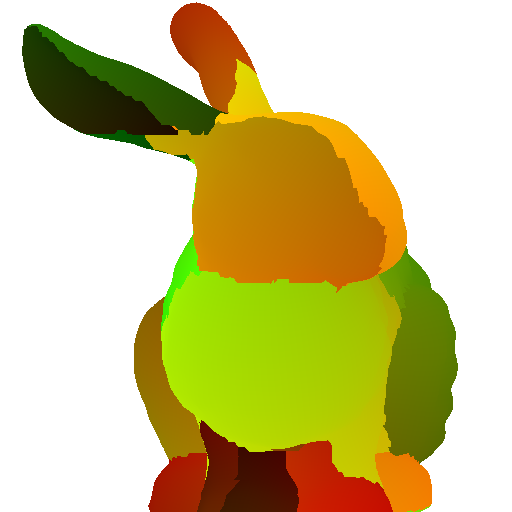

In [10]:
random_view_image = renderer.render_mesh(modelview=random_view, **mesh)
show.image(random_view_image)

Note that this image has an alpha channel to separate foreground from background, and the colors red and green encode the UV coordinates—where a pixel in the texture would end up on the model. We will use this information to take the gradient of the flat image coming from our CNN model and translate it back onto the texture we're learning/optimizing.

### CNN model

We want to synthesize a texture with some property that we can describe in the feature space of our pretrained CNN. For simplicity, we focus on a simple Feature Visualization objective here—but in the follow up notebook we will use a more complex style transfer objective for even more interesting results.

Let's start by loading up our CNN model as usual:

In [11]:
model = vision_models.InceptionV1()
model.load_graphdef()

And quickly see a simple 2D image optimized for the same Feature Visualization objective we'll later use to generate the 3D model's texture:

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x7f9b894cf130>



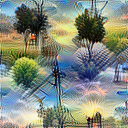

In [12]:
objective = objectives.channel('mixed4b_pool_reduce_pre_relu', 17)
vis = lucid_render.render_vis(model, objective, verbose=False) # (lucid.optvis.render is imported as lucid_render to differentiate it from the 3D renderer)
show.image(vis)

### Synthesize the texture

In [13]:
sess = create_session()

# t_fragments is used to feed rasterized UV coordinates for the current view.
# Channels: [U, V, _, Alpha]. Alpha is 1 for pixels covered by the object, and
# 0 for background.
t_fragments = tf.compat.v1.placeholder(tf.float32, [None, None, 4])
t_uv = t_fragments[...,:2]
t_alpha = t_fragments[...,3:]

t_texture = param.image(1024, fft=True, decorrelate=True)[0]
t_frame = sample_bilinear(t_texture, t_uv) * t_alpha

model.import_graph(t_frame)


def T(layer):
  return sess.graph.get_tensor_by_name("import/%s:0"%layer)

# obj = objectives.channel('mixed3a_1x1_pre_relu', 1)(T)
# obj = objectives.channel('mixed4a_1x1_pre_relu', 26)(T)
# obj = objectives.channel('mixed4a_1x1_pre_relu', 11)(T)
# obj = objectives.channel('mixed4a_3x3_pre_relu', 27)(T)
# obj = objectives.channel('mixed4a_3x3_pre_relu', 174)(T)
# obj = objectives.channel('mixed4a_1x1_pre_relu', 179)(T)
# obj = objectives.channel('mixed4a_1x1_pre_relu', 190)(T)
# obj = objectives.channel('mixed4a_1x1_pre_relu', 5)(T)

obj = objectives.channel('mixed4b_pool_reduce_pre_relu', 17)(T)
tf.compat.v1.losses.add_loss(-obj)


t_lr = tf.constant(0.01)
t_loss =  tf.compat.v1.losses.get_total_loss()
trainer = tf.compat.v1.train.AdamOptimizer(t_lr)
train_op = trainer.minimize(t_loss)

init_op =  tf.compat.v1.global_variables_initializer()
init_op.run()


We can sanity check that at least our parameterization fits together by generating the UV map again with the renderer ("`fragments`") and then `eval`ing the `t_frame` tensor while feeding the original texture:


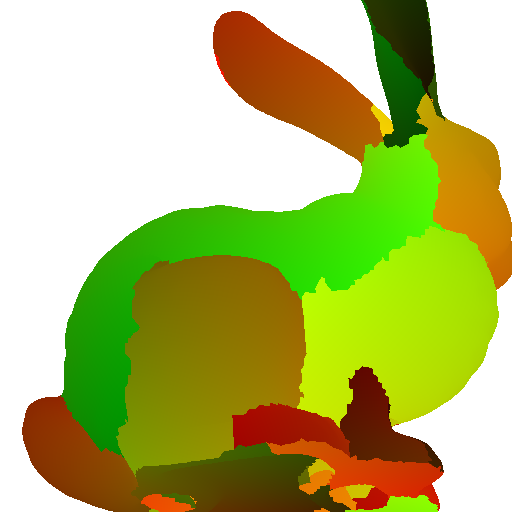
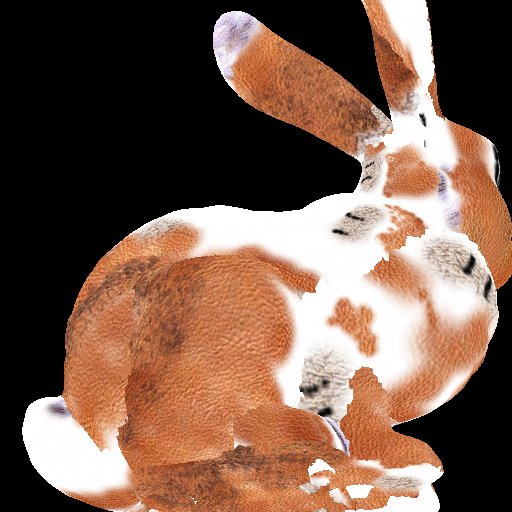

In [14]:
fragments = renderer.render_mesh(modelview=meshutil.sample_view(11.0, 13.0), **mesh)
img = t_frame.eval({t_fragments: fragments, t_texture: original_texture})
show.images([fragments, img])

Looks reasonable! Let's run the actual optimization loop and see if we can generate a texture!


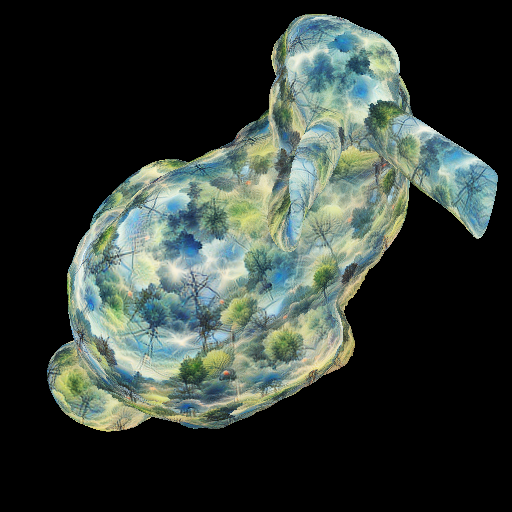
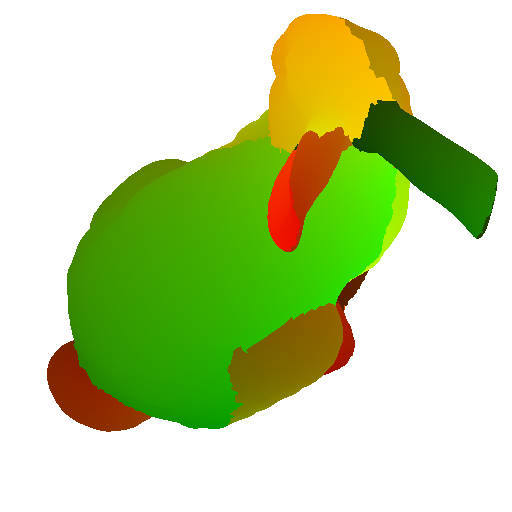

400 -219.99103


In [15]:
loss_log = []
init_op.run()

for i in range(400):
  
  # Render mesh UVs with OpenGL
  fragments = renderer.render_mesh(modelview=meshutil.sample_view(11.0, 13.0), **mesh)
  
  # Perform step optimization for the current view
  _, loss = sess.run([train_op, t_loss], {t_fragments: fragments, t_lr:0.03})
  loss_log.append(loss)
  
  # Reporting
  if i==0 or (i+1)%50 == 0:
    clear_output()
    last_frame = sess.run(t_frame, {t_fragments: fragments})
    show.images([last_frame, fragments], ['current', 'uv'])
    
  if i==0 or (i+1)%10 == 0:
    print(len(loss_log), loss)


Since this is such a stochastic procedure, it's good to sanity check that we observe the loss going down. Remember the loss only captures how well the final rendered image activates the feature we are optimizing for, while we view the 3D model from a different perspective at each time—so expect high variance.

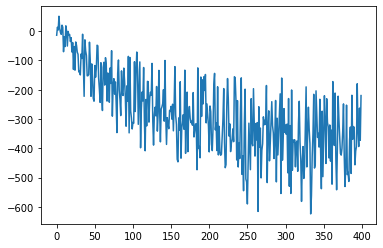

In [16]:
pl.plot(loss_log);

### View the result

In [17]:
texture = t_texture.eval()
show.textured_mesh(mesh, texture)

Output hidden; open in https://colab.research.google.com to view.

You can also view the texture we optimized directly:

In [18]:
show.image(texture, fmt='jpeg')